In [1]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 
from sklearn.metrics import mean_squared_error
from skimage.transform import resize
from scipy.signal.windows import gaussian
from scipy.signal import convolve2d
from skimage import util
from skimage.restoration import richardson_lucy as rl
from PIL import Image
from IPython.display import display



In [2]:

def gaussian_blur(img, kernel_size = 3):

    dummy = np.copy(img)

    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)

    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

In [3]:

def motion_blur(img,  kernel_size = 3):

    dummy = np.copy(img)

    h = np.eye(kernel_size) / kernel_size

    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

In [4]:
def inverse_filter(img, kernel):
    # Normalize the kernel to ensure it sums to 1
    kernel /= np.sum(kernel)
    
    # Create a copy of the input image and perform Fourier transform
    dummy = np.copy(img)
    dummy = fft2(dummy)
    
    # Perform Fourier transform on the kernel and pad it to match the image's size
    kernel = fft2(kernel, s=img.shape)
    
    # Avoid division by zero or very small values in the kernel
    epsilon = 1e-8
    kernel[np.abs(kernel) < epsilon] = epsilon  # Set small values to epsilon
    
    # Apply the inverse filter in the frequency domain (divide image by kernel)
    dummy = dummy / kernel
    
    # Perform the inverse Fourier transform to bring the image back to the spatial domain
    dummy = np.abs(ifft2(dummy))
    
    return dummy  # Return the restored image

 

In [5]:
def trunc_filter(img, kernel, radius):

    
    # Initialize the restored image array with the same shape as the input image
    restored = np.zeros_like(img)
    
    # Perform FFT on the grayscale image
    G = np.fft.fftshift(np.fft.fft2(img))  # FFT of the image
    
    # Pad the kernel to match the size of the image
    h_padded = np.zeros(img.shape)
    h_padded[:kernel.shape[0], :kernel.shape[1]] = np.copy(kernel)
    H = np.fft.fftshift(np.fft.fft2(h_padded))  # FFT of the padded kernel

    # Normalize the Fourier transforms
    H_norm = H / np.abs(H.max())
    G_norm = G / np.abs(G.max())
    
    # Apply truncation in the frequency domain
    F_temp = G_norm / H_norm
    F_norm = F_temp / np.abs(F_temp.max())
    
    # Rescale to original scale
    F_hat = F_norm * np.abs(G.max())
    
    # Create a mask for the inner and outer regions based on the specified radius
    circle_img = np.zeros(img.shape)
    cv2.circle(circle_img, (img.shape[0] // 2, img.shape[1] // 2), radius, 1, thickness=-1)  # Inner circle
    inner_F_hat = circle_img * F_hat  # Apply mask to the filtered result
    circle_img = 1 - circle_img  # Invert mask for the outer region
    outer_G = circle_img * G  # Apply mask to the original FFT

    # Inverse FFT to obtain the restored image
    f_hat = np.fft.ifft2(np.fft.ifftshift(inner_F_hat + outer_G))  
    restored = np.abs(f_hat)  # Store the result

    return restored  # Return the restored image


    

In [6]:
def wiener_filter(img, kernel, K):
    # Normalize the kernel by ensuring its sum is 1
    kernel /= np.sum(kernel)
    
    # Create a copy of the input image to avoid modifying the original
    dummy = np.copy(img)
    
    # Perform Fourier transform on the image to convert it to the frequency domain
    dummy = fft2(dummy)
    
    # Perform Fourier transform on the kernel, padded to match the image size
    kernel = fft2(kernel, s=img.shape)
    
    # Apply Wiener filtering: conjugate the kernel and use it with the regularization term (K)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    
    # Apply the filter by multiplying the transformed image with the filtered kernel
    dummy = dummy * kernel
    
    # Perform inverse Fourier transform to bring the result back to the spatial domain
    dummy = np.abs(ifft2(dummy))
    
    # Return the filtered image
    return dummy


In [8]:

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h
def motion_kernel(kernel_size=3):
    h = np.eye(kernel_size) / kernel_size
    return h

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Code showing the implementation of adding motion blur and different additive noises

In [9]:

file_name = os.path.join('braintumor.jpg') 
img = rgb2gray(plt.imread(file_name))

# motion blurred image
motion_blurred_img = motion_blur(img,  kernel_size = 3)

kernel = gaussian_kernel(7)

# Normalize the blurred image to [0, 1]
motion_blurred_img = (motion_blurred_img - np.min(motion_blurred_img)) / (np.max(motion_blurred_img) - np.min(motion_blurred_img))

# noisy_img =  add_gaussian_noise(blurred_img, sigma = 20)
var = 0.01
motion_noisy_img = util.random_noise(motion_blurred_img, mode="gaussian", var=var)

motion_noisy_img2 = util.random_noise(motion_blurred_img, mode="poisson")



Showing Motion Blurred Image with Additive Noises

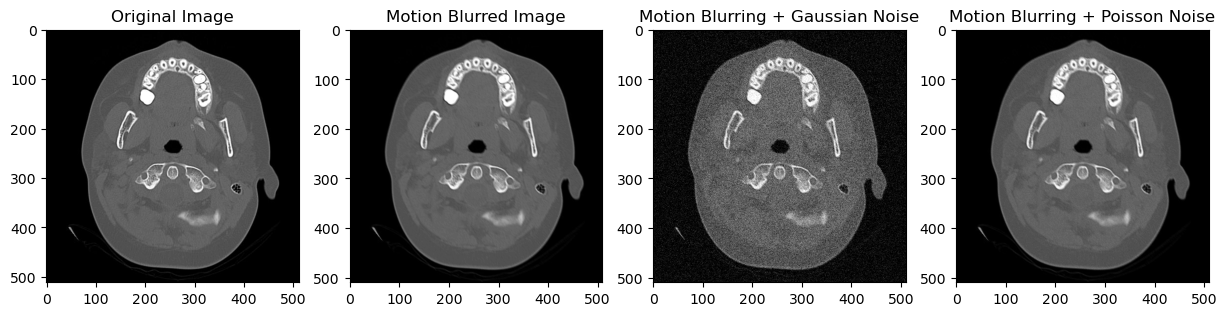

In [10]:
display = [img, motion_blurred_img, motion_noisy_img,motion_noisy_img2]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Motion Blurring + Poisson Noise']

fig = plt.figure(figsize=(15, 5))  # Adjust the figsize for a horizontal layout

for i in range(len(display)):
    fig.add_subplot(1, 4, i+1)  # Set 1 row and 3 columns
    plt.imshow(display[i], cmap='gray')
    plt.title(label[i])

plt.show()


In [11]:
# gaussian blurred image
gaussian_blurred_img = gaussian_blur(img,  kernel_size = 3)

# Normalize the blurred image to [0, 1]
gaussian_blurred_img = (gaussian_blurred_img - np.min(gaussian_blurred_img)) / (np.max(gaussian_blurred_img) - np.min(gaussian_blurred_img))

# noisy_img =  add_gaussian_noise(blurred_img, sigma = 20)
var = 0.01
gaussian_noisy_img = util.random_noise(gaussian_blurred_img, mode="gaussian", var=var)

gaussian_noisy_img2 = util.random_noise(gaussian_blurred_img, mode="poisson")


Displaying Gaussian Blurred Images with additive noises

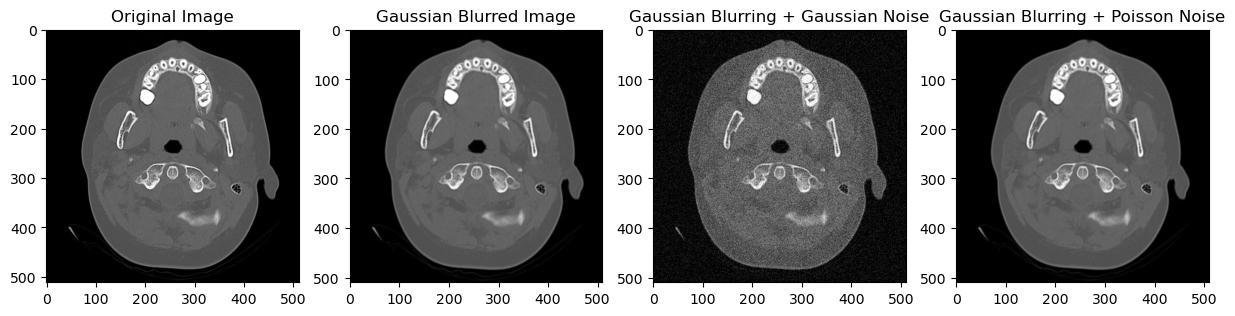

In [12]:
display = [img, gaussian_blurred_img, gaussian_noisy_img, gaussian_noisy_img2]
label = ['Original Image', 'Gaussian Blurred Image', 'Gaussian Blurring + Gaussian Noise', 'Gaussian Blurring + Poisson Noise']

fig = plt.figure(figsize=(15, 5))  # Adjust the figsize for a horizontal layout

for i in range(len(display)):
    fig.add_subplot(1, 4, i+1)  # Set 1 row and 3 columns
    plt.imshow(display[i], cmap='gray')
    plt.title(label[i])

plt.show()


Applying filters to images with Motion Blur

In [13]:


# applying the filters to images with motion blur + gaussian noise
m_inv_filtered_img = inverse_filter(motion_noisy_img,kernel)
# trunc_inv_img = trunc_filter(noisy_img, kernel, 40)
m_w_filtered_img = wiener_filter(motion_noisy_img, kernel, K = 30)
m_rl_img = rl(motion_noisy_img,kernel, 25)

# applying the filters to images with motion blur + poisson noise
m_inv_filtered_img2 = inverse_filter(motion_noisy_img2,kernel)
# trunc_inv_img2 = trunc_filter(noisy_img2, kernel, 40)
m_w_filtered_img2 = wiener_filter(motion_noisy_img2, kernel, K = 30)
m_rl_img2 = rl(motion_noisy_img2,kernel, 25)

Applying filters to images with Gaussian Blur

In [14]:

# gaussian_kernel = gaussian_kernel(5)


# applying the filters to images with gaussian blur + gaussian noise
g_inv_filtered_img = inverse_filter(gaussian_noisy_img,kernel)
# trunc_inv_img = trunc_filter(noisy_img, kernel, 40)
g_w_filtered_img = wiener_filter(gaussian_noisy_img, kernel, K = 30)
g_rl_img = rl(gaussian_noisy_img,kernel, 25)

# applying the filters to images with gaussian blur + poisson noise
g_inv_filtered_img2 = inverse_filter(gaussian_noisy_img2,kernel)
# trunc_inv_img2 = trunc_filter(noisy_img2, kernel, 40)
g_w_filtered_img2 = wiener_filter(gaussian_noisy_img2, kernel, K = 30)
g_rl_img2 = rl(gaussian_noisy_img2,kernel, 25)

Displaying the images with Filters applied with Motion Blur

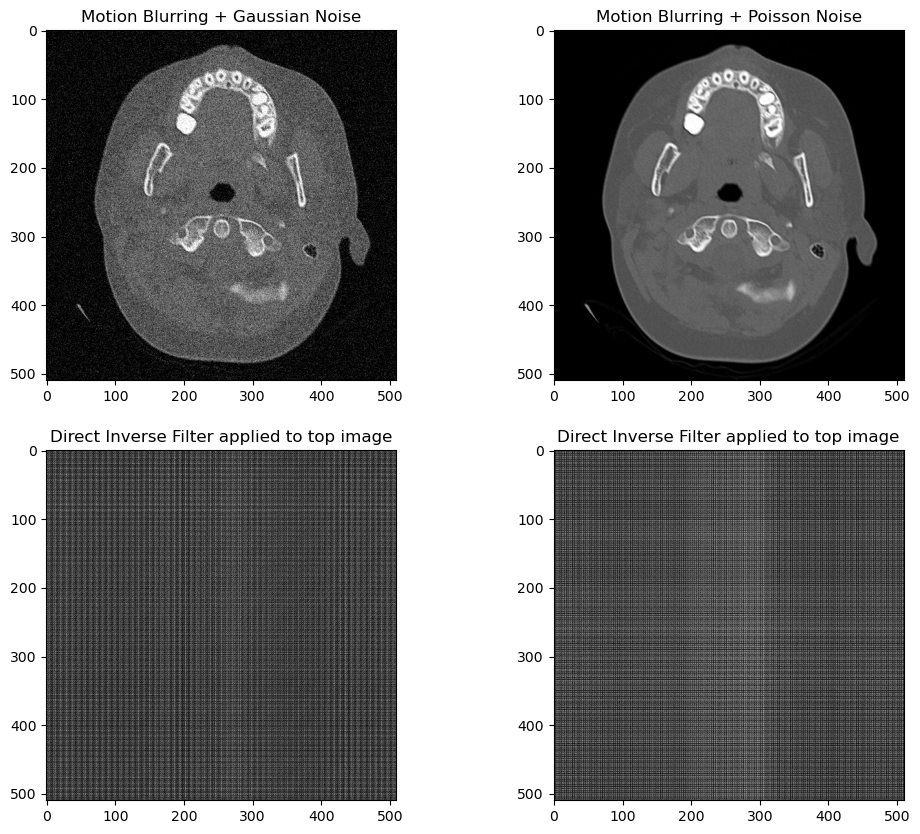

In [15]:
display = [ motion_noisy_img, motion_noisy_img2,  m_inv_filtered_img,m_inv_filtered_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Direct Inverse Filter applied to top image', 'Direct Inverse Filter applied to top image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Applying Direct Inverse Filter to Gaussian Blurred Images

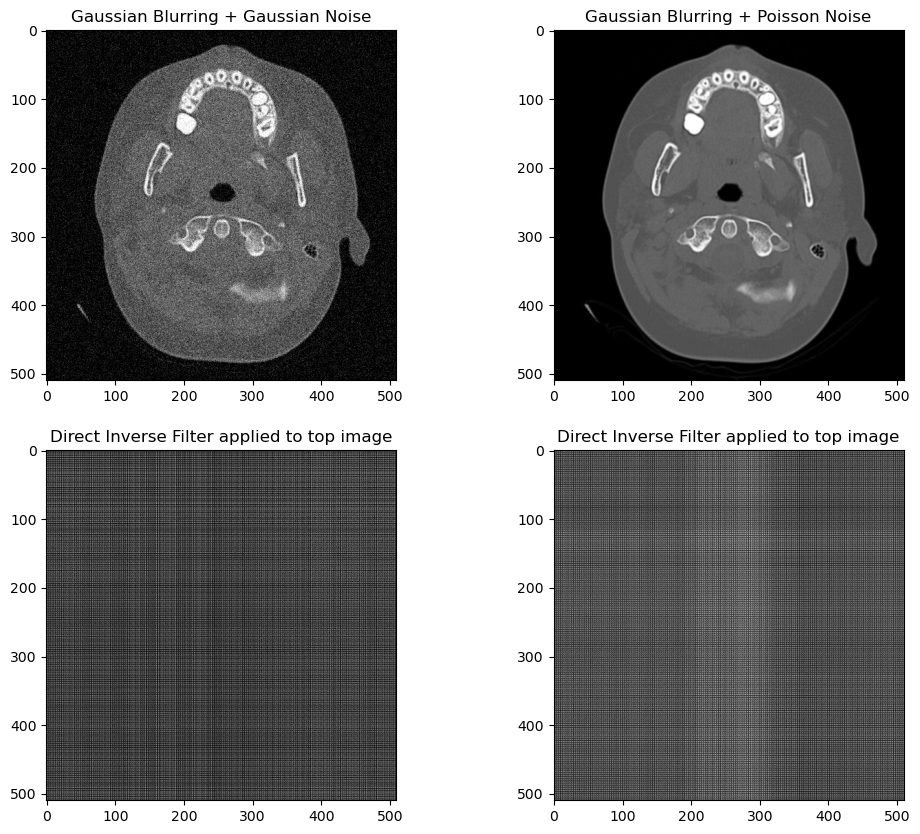

In [17]:
display = [ gaussian_noisy_img, gaussian_noisy_img2, g_inv_filtered_img, g_inv_filtered_img2]
label = [ 'Gaussian Blurring + Gaussian Noise','Gaussian Blurring + Poisson Noise', 'Direct Inverse Filter applied to top image', 'Direct Inverse Filter applied to top image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

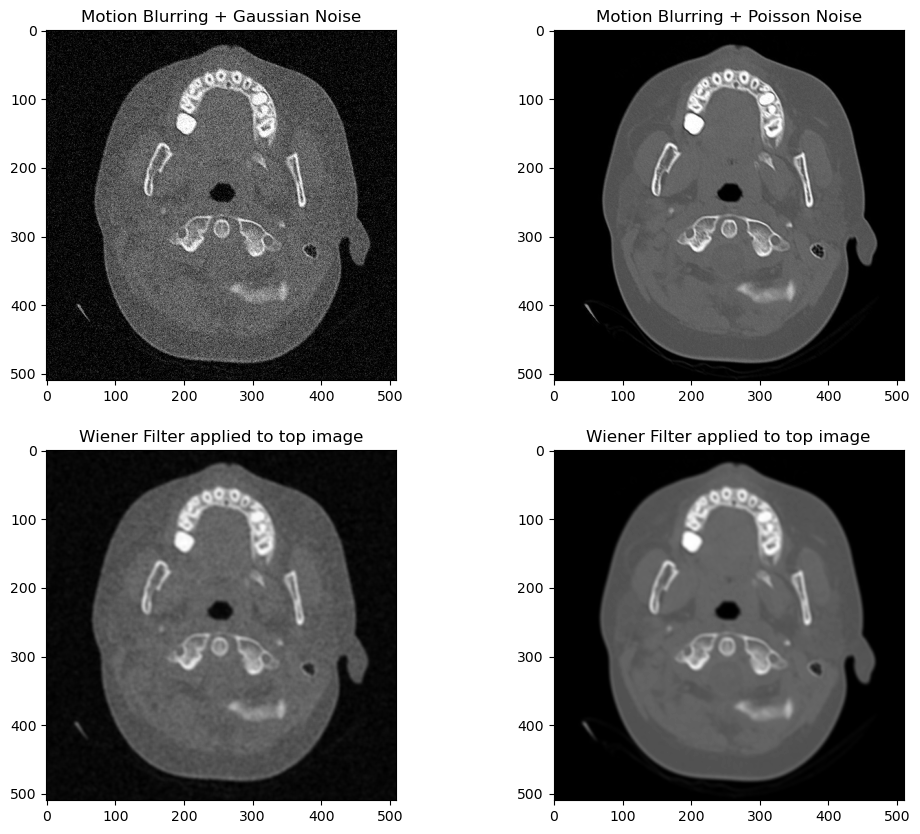

In [18]:
display = [ motion_noisy_img, motion_noisy_img2,  m_w_filtered_img, m_w_filtered_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Wiener Filter applied to top image', 'Wiener Filter applied to top image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Richardson-Lucy Algorithm Applied to images with Motion Blur

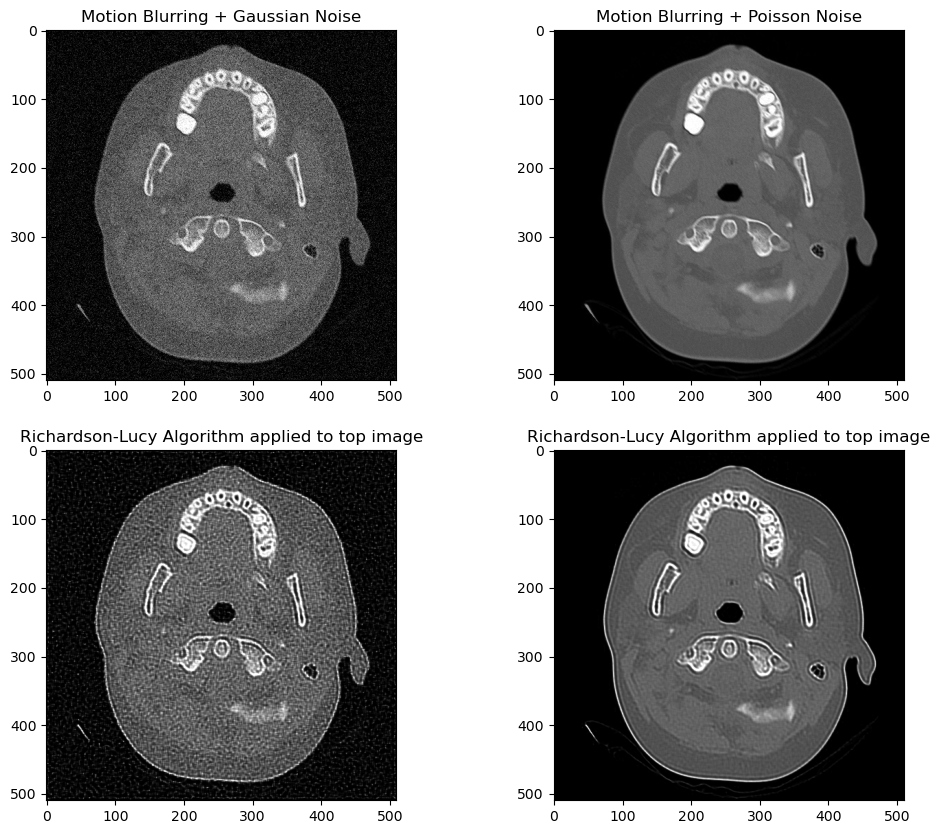

In [19]:

display = [motion_noisy_img, motion_noisy_img2,  m_rl_img, m_rl_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Richardson-Lucy Algorithm applied to top image', 'Richardson-Lucy Algorithm applied to top image']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Richardson-Lucy Algorithm Applied to images with Gaussian Blur

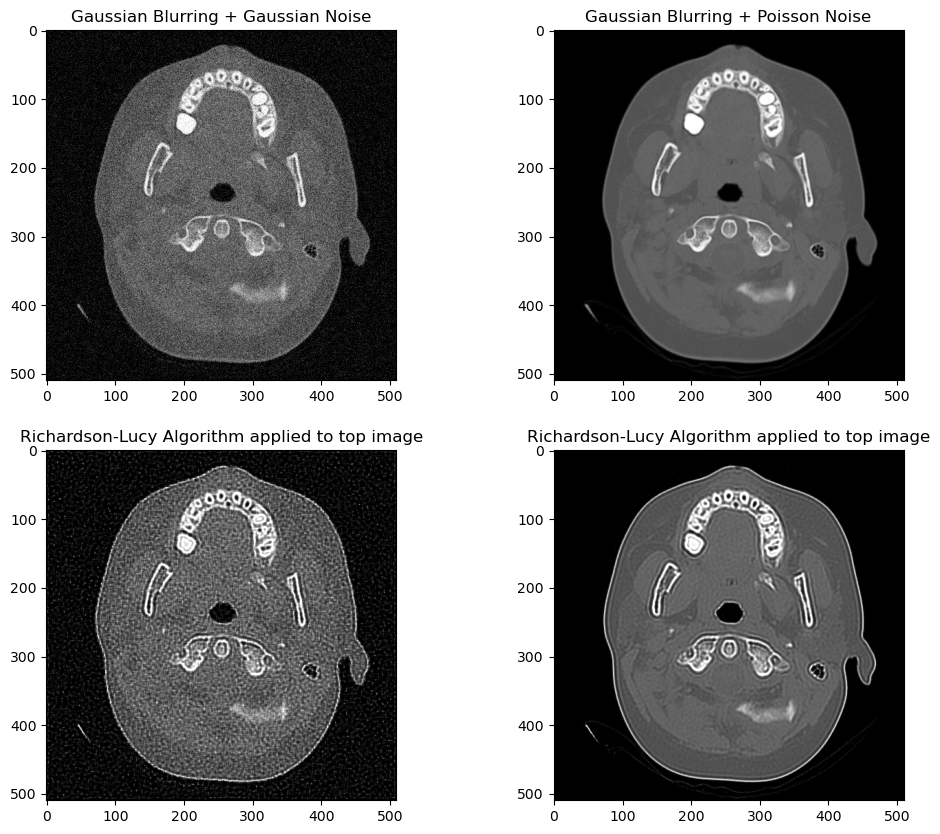

In [20]:


display = [gaussian_noisy_img, gaussian_noisy_img2,  g_rl_img, g_rl_img2]
label = [ 'Gaussian Blurring + Gaussian Noise','Gaussian Blurring + Poisson Noise', 'Richardson-Lucy Algorithm applied to top image', 'Richardson-Lucy Algorithm applied to top image']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Code in Calculating PSNR and SSIM for the applied filters

In [21]:

img = cv2.resize(img, (256, 256))

# resizing the restored images so the psnr and ssim can be calculated
m_inv_filtered_img = resize(m_inv_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
# trunc_inv_img = resize(trunc_inv_img, img.shape, mode='reflect', anti_aliasing=True)
m_w_filtered_img = resize(m_w_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
m_rl_img = resize(m_rl_img, img.shape, mode='reflect', anti_aliasing=True)

# resizing the restored images so the psnr and ssim can be calculated
m_inv_filtered_img2 = resize(m_inv_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
# trunc_inv_img2 = resize(trunc_inv_img2, img.shape, mode='reflect', anti_aliasing=True)
m_w_filtered_img2 = resize(m_w_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
m_rl_img2 = resize(m_rl_img2, img.shape, mode='reflect', anti_aliasing=True)



g_inv_filtered_img = resize(g_inv_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
# trunc_inv_img = resize(trunc_inv_img, img.shape, mode='reflect', anti_aliasing=True)
g_w_filtered_img = resize(g_w_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
g_rl_img = resize(g_rl_img, img.shape, mode='reflect', anti_aliasing=True)

# resizing the restored images so the psnr and ssim can be calculated
g_inv_filtered_img2 = resize(g_inv_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
# trunc_inv_img2 = resize(trunc_inv_img2, img.shape, mode='reflect', anti_aliasing=True)
g_w_filtered_img2 = resize(g_w_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
g_rl_img2 = resize(g_rl_img2, img.shape, mode='reflect', anti_aliasing=True)



# If your images are in the range [0, 255]
data_range = 255.0


Calculating PSNR Values

In [22]:
# Calculate PSNR for Motion blur + Gaussian Noise
m_inv_filtered_psnr_value = peak_signal_noise_ratio(img, m_inv_filtered_img, data_range=data_range)
# trunc_inv_psnr_value = peak_signal_noise_ratio(img, trunc_inv_img, data_range=data_range)
m_w_psnr_value = peak_signal_noise_ratio(img, m_w_filtered_img, data_range=data_range)
m_rl_psnr_value = peak_signal_noise_ratio(img, m_rl_img, data_range=data_range)

# Calculate PSNR for Motion blur +  Poisson Noise
m_inv_filtered_psnr_value2 = peak_signal_noise_ratio(img, m_inv_filtered_img2, data_range=data_range)
# trunc_inv_psnr_value2 = peak_signal_noise_ratio(img, trunc_inv_img2, data_range=data_range)
m_w_psnr_value2 = peak_signal_noise_ratio(img, m_w_filtered_img2, data_range=data_range)
m_rl_psnr_value2 = peak_signal_noise_ratio(img, m_rl_img2, data_range=data_range)

# Calculate PSNR for Gaussian blur + Gaussian Noise
g_inv_filtered_psnr_value = peak_signal_noise_ratio(img, g_inv_filtered_img, data_range=data_range)
# trunc_inv_psnr_value = peak_signal_noise_ratio(img, trunc_inv_img, data_range=data_range)
g_w_psnr_value = peak_signal_noise_ratio(img, g_w_filtered_img, data_range=data_range)
g_rl_psnr_value = peak_signal_noise_ratio(img, g_rl_img, data_range=data_range)

# Calculate PSNR for Gaussian blur +  Poisson Noise
g_inv_filtered_psnr_value2 = peak_signal_noise_ratio(g_inv_filtered_img2,img, data_range=data_range)
# trunc_inv_psnr_value2 = peak_signal_noise_ratio(img, trunc_inv_img2, data_range=data_range)
g_w_psnr_value2 = peak_signal_noise_ratio(img, g_w_filtered_img2, data_range=data_range)
g_rl_psnr_value2 = peak_signal_noise_ratio(img, g_rl_img2, data_range=data_range)


print(m_inv_filtered_psnr_value)
print(m_w_psnr_value2)
print(m_rl_psnr_value2)






-29.14566249242061
10.381235251160469
10.414172976490267


Calculating SSIM Values

In [23]:
# Calculate SSIM for Motion blur + Gaussian Noise
m_inv_ssim = structural_similarity(img, m_inv_filtered_img, data_range=data_range)
# trunc_inv_ssim = structural_similarity(img, trunc_inv_img, data_range=data_range)
m_w_ssim =  structural_similarity(img, m_w_filtered_img, data_range=data_range)
m_rl_ssim = structural_similarity(img, m_rl_img, data_range=data_range)

# Calculate SSIM for Motion blur + Poisson Noise
m_inv_ssim2 = structural_similarity(img, m_inv_filtered_img, data_range=data_range)
# trunc_inv_ssim2 = structural_similarity(img, trunc_inv_img, data_range=data_range)
m_w_ssim2 =  structural_similarity(img, m_w_filtered_img, data_range=data_range)
m_rl_ssim2 = structural_similarity(img, m_rl_img, data_range=data_range)


# Calculate SSIM for Gaussian blur + Gaussian Noise
g_inv_ssim = structural_similarity(img, g_inv_filtered_img, data_range=data_range)
# trunc_inv_ssim = structural_similarity(img, trunc_inv_img, data_range=data_range)
g_w_ssim =  structural_similarity(img, g_w_filtered_img, data_range=data_range)
g_rl_ssim = structural_similarity(img, g_rl_img, data_range=data_range)

# Calculate SSIM for Gaussian blur + Poisson Noise
g_inv_ssim2 = structural_similarity(img, g_inv_filtered_img, data_range=data_range)
# trunc_inv_ssim2 = structural_similarity(img, trunc_inv_img, data_range=data_range)
g_w_ssim2 =  structural_similarity(img, g_w_filtered_img, data_range=data_range)
g_rl_ssim2 = structural_similarity(img, g_rl_img, data_range=data_range)

Motion Blur + Gaussian Noise PSNR AND SSIM

In [36]:
# printing PSNR for Filters applied to Motion Blur + Gaussian Noise
print("Motion Blur + Gaussian Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{m_inv_filtered_psnr_value:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_psnr_value:.5f}")
print(f"Wiener Filter PSNR: {m_w_psnr_value:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {m_rl_psnr_value:.5}")
print()


# printing SSIM Filters applied to Motion Blur + Gaussian Noise
print("SSIM Values")
print(f"Direct Inverse Filter SSIM:{m_inv_ssim:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_ssim:.5f}")
print(f"Wiener Filter PSNR: {m_w_ssim:.5f}")
print(f"Richardson Lucy Algorithm SSIM: {m_rl_ssim:.5f}")



Motion Blur + Gaussian Noise
PSNR Values
Direct Inverse Filter PSNR:-29.14566
Wiener Inverse Filter PSNR: 10.38123
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter SSIM:-0.00000
Wiener Filter PSNR: 0.36136
Richardson Lucy Algorithm SSIM: 0.36457


Graphing PSNR and SSIM for Motion Blur + Gaussian Noise

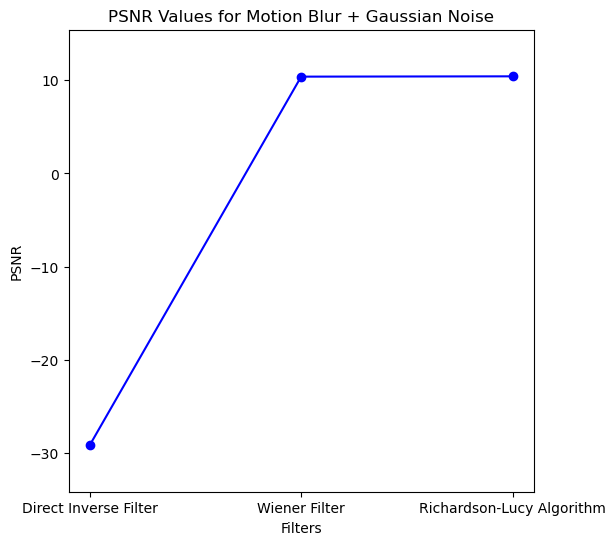

In [37]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [m_inv_filtered_psnr_value, m_w_psnr_value, m_rl_psnr_value]
ssim_values = [m_inv_ssim, m_w_ssim,m_rl_ssim]

plt.figure(figsize=(6, 6))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='blue')
plt.title('PSNR Values for Motion Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)

plt.show()


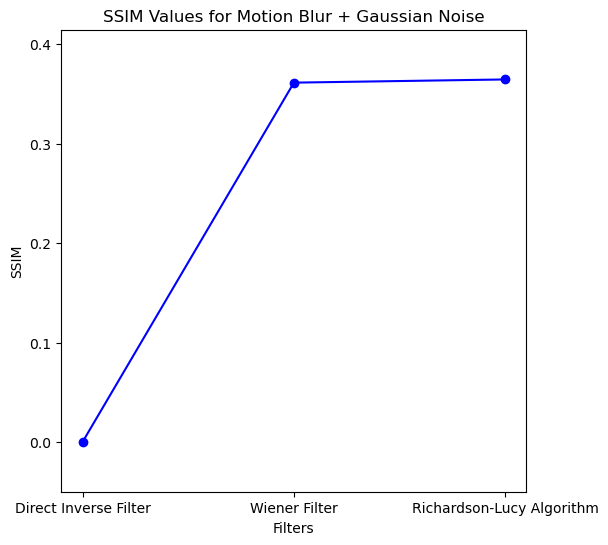

In [38]:
plt.figure(figsize=(6, 6))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Motion Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.05, max(ssim_values) + 0.05)

plt.show()

Motion Blur + Poisson Noise PSNR AND SSIM

In [39]:
# printing PSNR for Filters applied to Motion Blur + Poisson Noise
print("Motion Blur + Poisson Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{m_inv_filtered_psnr_value2:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_psnr_value2:.5f}")
print(f"Wiener Inverse Filter PSNR: {m_w_psnr_value2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {m_rl_psnr_value2:.5}")
print()


# printing SSIM Filters applied to Motion Blur + Poisson Noise
print("SSIM Values")
print(f"Direct Inverse Filter PSNR:{m_inv_ssim2:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_ssim2:.5f}")
print(f"Wiener Inverse Filter PSNR: {m_w_ssim2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {m_rl_ssim2:.5f}")


Motion Blur + Poisson Noise
PSNR Values
Direct Inverse Filter PSNR:-14.98648
Wiener Inverse Filter PSNR: 10.38124
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter PSNR:-0.00000
Wiener Inverse Filter PSNR: 0.36136
Richardson Lucy Algorithm PSNR: 0.36457


Graphing PSNR and SSIM for Motion Blur + Poisson Noise

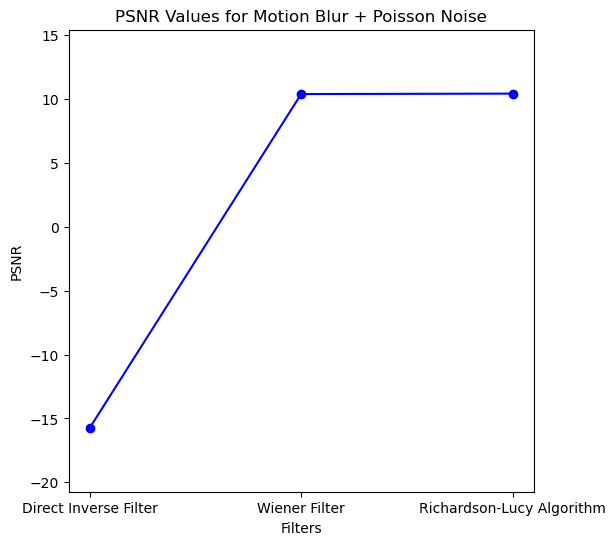

In [403]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [m_inv_filtered_psnr_value2, m_w_psnr_value2, m_rl_psnr_value2]
ssim_values = [m_inv_ssim2, m_w_ssim2,m_rl_ssim2]

plt.figure(figsize=(6, 6))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='blue')
plt.title('PSNR Values for Motion Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)


plt.show()


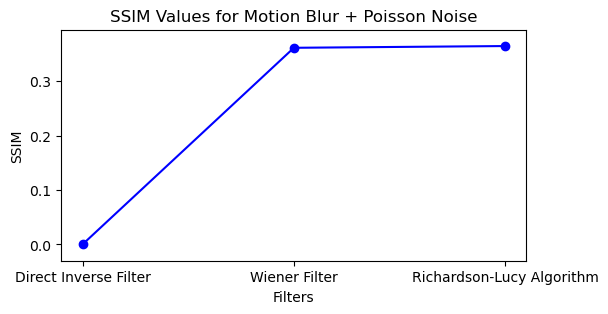

In [28]:
plt.figure(figsize=(6, 3))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Motion Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.03, max(ssim_values) + 0.03)

plt.show()

Gaussian Blur + Gaussian Noise PSNR AND SSIM

In [40]:
# printing PSNR for Filters applied to Gaussian Blur + Gaussian Noise
print("Gaussian Blur + Gaussian Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{g_inv_filtered_psnr_value:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_psnr_value:.5f}")
print(f"Wiener Inverse Filter PSNR: {g_w_psnr_value:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {g_rl_psnr_value:.5}")
print()


# printing SSIM Filters applied to Gaussian Blur + Gaussian Noise
print("SSIM Values")
print(f"Direct Inverse Filter PSNR:{g_inv_ssim:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_ssim:.5f}")
print(f"Wiener Inverse Filter PSNR: {g_w_ssim:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {g_rl_ssim:.5f}")


Gaussian Blur + Gaussian Noise
PSNR Values
Direct Inverse Filter PSNR:-30.39513
Wiener Inverse Filter PSNR: 10.38123
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter PSNR:-0.00000
Wiener Inverse Filter PSNR: 0.36136
Richardson Lucy Algorithm PSNR: 0.36459


Graphing PSNR and SSIM for Gaussian Blur + Gaussian Noise

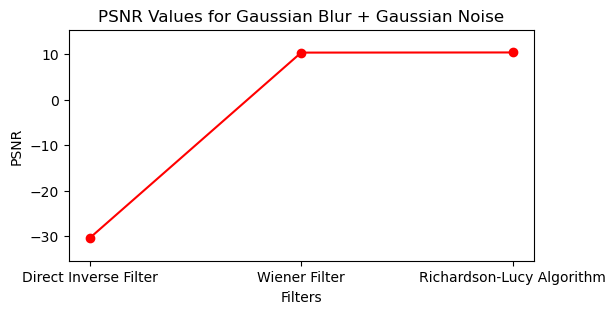

In [41]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [g_inv_filtered_psnr_value, g_w_psnr_value, g_rl_psnr_value]
ssim_values = [g_inv_ssim, g_w_ssim, g_rl_ssim]

plt.figure(figsize=(6, 3))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='red')
plt.title('PSNR Values for Gaussian Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)



plt.show()


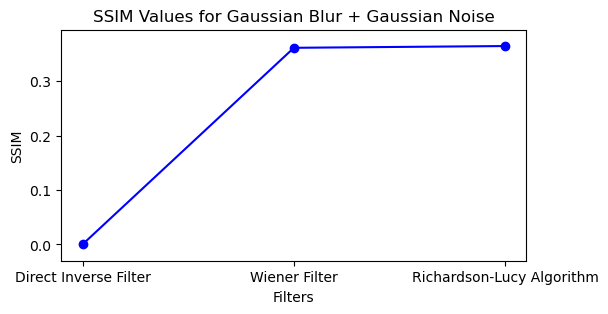

In [42]:
plt.figure(figsize=(6, 3))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Gaussian Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.03, max(ssim_values) + 0.03)


plt.show()

Gaussian Blur + Poisson Noise PSNR AND SSIM

In [44]:
# printing PSNR for Filters applied to Gaussian Blur + Poisson Noise
print("Gaussian Blur + Poisson Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{g_inv_filtered_psnr_value2:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_psnr_value:.5f}")
print(f"Wiener Inverse Filter PSNR: {g_w_psnr_value2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {g_rl_psnr_value2:.5}")
print()


# printing SSIM Filters applied to Gaussian Blur + Gaussian Noise
print("SSIM Values")
print(f"Direct Inverse Filter PSNR:{g_inv_ssim2:.5f}")
# print(f"Truncated Inverse Filter PSNR:{trunc_inv_ssim:.5f}")
print(f"Wiener Inverse Filter PSNR: {g_w_ssim2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {g_rl_ssim2:.5f}")


Gaussian Blur + Poisson Noise
PSNR Values
Direct Inverse Filter PSNR:-6.53634
Wiener Inverse Filter PSNR: 10.38124
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter PSNR:-0.00000
Wiener Inverse Filter PSNR: 0.36136
Richardson Lucy Algorithm PSNR: 0.36459


Graphing for Gaussian Blur + Poisson Noise

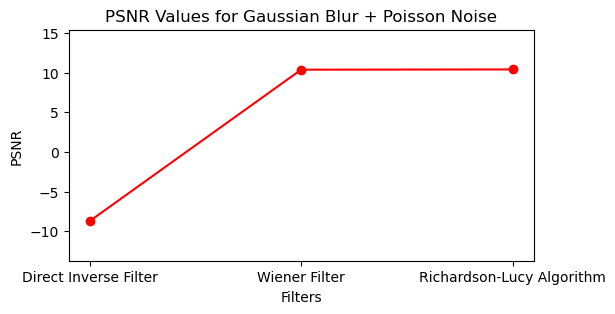

In [345]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [g_inv_filtered_psnr_value2, g_w_psnr_value2, g_rl_psnr_value2]
ssim_values = [g_inv_ssim2, g_w_ssim2, g_rl_ssim2]

plt.figure(figsize=(6, 3))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='red')
plt.title('PSNR Values for Gaussian Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)


plt.show()


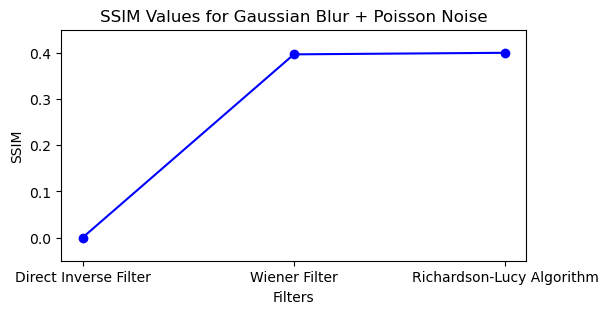

In [346]:
plt.figure(figsize=(6, 3))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Gaussian Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.05, max(ssim_values) + 0.05)
plt.show()

Taking average PSNR and SSIM Values

In [45]:
average_inv_psnr = (m_inv_filtered_psnr_value + m_inv_filtered_psnr_value2+g_inv_filtered_psnr_value+ g_inv_filtered_psnr_value2)/ 4.0
average_w_psnr = (m_w_psnr_value + m_w_psnr_value2+g_w_psnr_value+ g_w_psnr_value2)/ 4.0
average_rl_psnr = (m_rl_psnr_value + m_rl_psnr_value2+g_rl_psnr_value+ g_rl_psnr_value2)/ 4.0
 
average_inv_ssim = (m_inv_ssim + m_inv_ssim2 + g_inv_ssim + g_inv_ssim2)/ 4.0
average_w_ssim = (m_w_ssim + m_w_ssim2+g_w_ssim+ g_w_ssim2)/ 4.0
average_rl_ssim = (m_rl_ssim + m_rl_ssim2+g_rl_ssim+ g_rl_ssim2)/ 4.0


In [46]:
print(f"Average PSNR for Direct Inverse Filter: {average_inv_psnr:.7f}")
print(f"Average PSNR for Wiener Filter: {average_w_psnr:.7f}")
print(f"Average PSNR for Richarson-Lucy Algorithm: {average_rl_psnr:.7f}")
print()

print(f"Average SSIM for Direct Inverse Filter: {average_inv_ssim:.7f}")
print(f"Average SSIM for Wiener Filter: {average_w_ssim:.7f}")
print(f"Average SSIM for Richardson-Lucy Algorithm: {average_rl_ssim:.7f}")




Average PSNR for Direct Inverse Filter: -20.2659021
Average PSNR for Wiener Filter: 10.3812345
Average PSNR for Richarson-Lucy Algorithm: 10.4140931

Average SSIM for Direct Inverse Filter: -0.0000014
Average SSIM for Wiener Filter: 0.3613612
Average SSIM for Richardson-Lucy Algorithm: 0.3645800


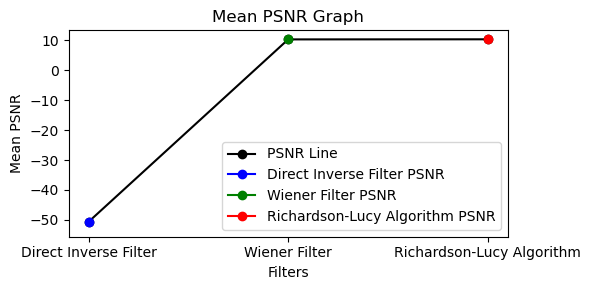

In [392]:

# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [average_inv_psnr, average_w_psnr, average_rl_psnr]

# Colors for each filter's marker
colors = ['blue', 'green', 'red']

plt.figure(figsize=(6, 3))

# Plot the PSNR values as a connected line
plt.plot(filters, psnr_values, marker='o', linestyle='-', color='black', label='PSNR Line')

# Plot each point with its respective color for better differentiation
for i, filter_name in enumerate(filters):
    plt.plot(filter_name, psnr_values[i], marker='o', color=colors[i], label=f'{filter_name} PSNR')

# Add title and labels
plt.title('Mean PSNR Graph')
plt.xlabel('Filters')
plt.ylabel('Mean PSNR')

# Set the y-axis limits
plt.ylim(min(psnr_values)-5, max(psnr_values) + 3)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



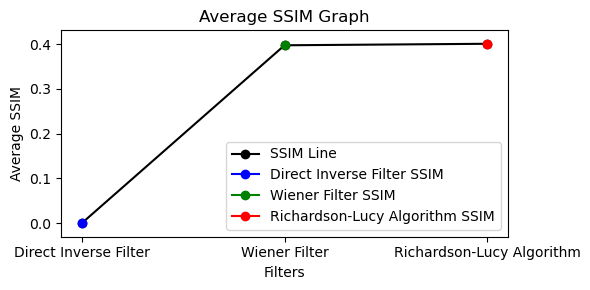

In [393]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
ssim_values = [average_inv_ssim, average_w_ssim, average_rl_ssim]

# Colors for each filter's marker
colors = ['blue', 'green', 'red']

plt.figure(figsize=(6, 3))

# Plot SSIM values as a connected line
plt.plot(filters, ssim_values, marker='o', linestyle='-', color='black', label='SSIM Line')

# Plot each SSIM point with its respective color
for i, filter_name in enumerate(filters):
    plt.plot(filter_name, ssim_values[i], marker='o', color=colors[i], label=f'{filter_name} SSIM')

# Add title and labels
plt.title('Average SSIM Graph')
plt.xlabel('Filters')
plt.ylabel('Average SSIM')

# Set the y-axis limits to fit the SSIM values
plt.ylim(min(ssim_values) - 0.03, max(ssim_values) + 0.03)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
